In [3]:
# Визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
plt.style.use("bmh")
plt.rcParams["axes.titlesize"] = "large"

In [5]:
# Общеe
import os
import tqdm
import pathlib
import numpy as np
import pandas as pd

tqdm.tqdm.pandas()
pd.set_option('display.max_columns', None)

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor

<div class="alert alert-block alert-warning">
Не забудьте заменить <tt>DATA_DIR</tt> на имя локальной директории, в которую сохранили файл.
</div>

In [5]:
DATA_DIR = pathlib.Path("/")
RS = 3984765

# Загрузка данных

Данные хранятся в формате Parquet: читается быстрее, места занимает меньше.

In [6]:
!pip install fastparquet
train = pd.read_parquet("/kaggle/input/sibur23/train.parquet")
train.head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.1 MB/s eta 0:00:00a 0:00:01


feature0   feature1   feature2   feature3 feature4   feature5   feature6  \
0  32.910908  17.376350  77.557840   2.929855     gas1  20.487150  57.633085   
1  41.263782  22.419445  47.945514 -25.847472     gas2  21.461239   3.474080   
2  25.580283  17.376350  77.654180   2.799411     gas1  20.487150  28.938295   
3  33.756900  17.376350  73.049625   2.953982     gas1  20.487150  28.932311   
4   4.223732  38.772534  48.015553 -25.843943     gas2  24.635721  12.011581   

    feature7   feature8   feature9  feature10  feature11  feature12  \
0  49.245392 -44.124381  23.400064 -28.640648 -10.995420  40.856313   
1  49.659980 -13.553188 -13.047593 -12.445940  16.657368  42.453280   
2  49.245392 -44.124381  20.610679 -28.641150  -1.886830  40.927941   
3  49.245392 -44.124381  18.107963 -28.642094  16.284415  40.869406   
4  51.030938  84.244199 -17.735680  40.395582  16.557978  65.988300   

   feature13   feature14  feature15  feature16  feature17  feature18  \
0  29.912800   33.168114  18.769718  41.812507  14.203652   9.689942   
1  99.792375  127.159321 -13.180244  50.722470 -14.451904  -0.906120   
2  16.340674   60.760647  18.658501  52.731646  14.395054   9.779019   
3  43.707663   48.037510  18.771030  52.305692  14.184314   9.798969   
4  91.081310  150.949700 -13.172169  51.012294 -14.439953   8.262354   

    feature19  feature20   feature21   feature22  feature23   feature24  \
0   17.951627  24.198589  102.448710  110.529868  56.817260   12.887802   
1  105.724742  -9.435222  -16.060150   37.286110  61.224272   39.822424   
2   17.951638  24.999453  101.728213  111.471534  52.664304   12.887802   
3   17.951675  23.990300  101.312113  115.589451  56.840719   12.887802   
4   90.187207  -2.901661  -16.060150   37.398779  40.488468  128.295838   

     target0    target1  
0  27.050891   6.502743  
1  84.127890  76.578716  
2  22.080133   3.036043  
3  30.234082   8.910795  
4  71.128092  50.475082

В данных есть один категориальный признак: `feature4`. Он может принимать значения `gas1` и `gas2`. Таргета два: `target0` и `target1`.

In [7]:
CAT = ["feature4"]
TARGETS = ["target0", "target1"]
FTS = train.filter(like="feature").columns.difference(CAT)

Проверяем, что с пропусками:

In [8]:
train.isnull().any().mean()

0.0

Их нет! Вот это поворот! Посмотрим на таргеты:

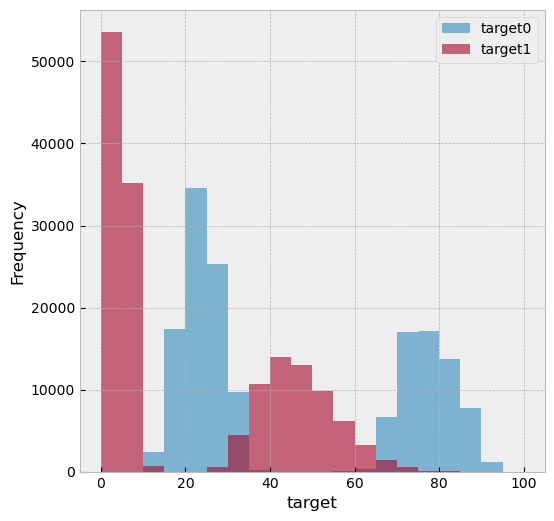

In [8]:
plt.figure(figsize=(6,6))

train[TARGETS].plot(kind="hist", range=(0, 100), bins=20, alpha=0.6, ax=plt.gca())
plt.xlabel("target");

Категориальный признак меняем на числовой:

In [9]:
train["gas"] = 0
train.loc[train.feature4=="gas2", "gas"] = 1

In [10]:
FTS = FTS.union(["gas"])

In [12]:
train

feature0   feature1   feature2   feature3 feature4   feature5  \
0       32.910908  17.376350  77.557840   2.929855     gas1  20.487150   
1       41.263782  22.419445  47.945514 -25.847472     gas2  21.461239   
2       25.580283  17.376350  77.654180   2.799411     gas1  20.487150   
3       33.756900  17.376350  73.049625   2.953982     gas1  20.487150   
4        4.223732  38.772534  48.015553 -25.843943     gas2  24.635721   
...           ...        ...        ...        ...      ...        ...   
153412  25.851721  17.376350  69.777513   3.086227     gas1  20.487150   
153413  33.211644  17.376350  84.113483   2.963000     gas1  20.487150   
153414   0.339018  17.376350  77.627839   2.889655     gas1  20.487150   
153415  21.018093  38.902218  48.015239 -25.843954     gas2  24.642608   
153416  -5.844710  17.376350  67.034869   2.841693     gas1  20.487150   

         feature6   feature7   feature8   feature9  feature10  feature11  \
0       57.633085  49.245392 -44.124381  23.400064 -28.640648 -10.995420   
1        3.474080  49.659980 -13.553188 -13.047593 -12.445940  16.657368   
2       28.938295  49.245392 -44.124381  20.610679 -28.641150  -1.886830   
3       28.932311  49.245392 -44.124381  18.107963 -28.642094  16.284415   
4       12.011581  51.030938  84.244199 -17.735680  40.395582  16.557978   
...           ...        ...        ...        ...        ...        ...   
153412   9.187947  49.245392 -44.124381   8.395057 -28.641157  25.687912   
153413  37.677592  49.245392 -44.124381   6.252886 -28.641255  99.694891   
153414  49.094915  49.245392 -44.124381  23.596678 -28.640526  25.816561   
153415   0.626815  51.022655  84.812493 -30.045713  40.703237  -1.855328   
153416  51.994539  49.245392 -44.124381   1.736551 -28.642195  25.631322   

        feature12  feature13   feature14  feature15  feature16  feature17  \
0       40.856313  29.912800   33.168114  18.769718  41.812507  14.203652   
1       42.453280  99.792375  127.159321 -13.180244  50.722470 -14.451904   
2       40.927941  16.340674   60.760647  18.658501  52.731646  14.395054   
3       40.869406  43.707663   48.037510  18.771030  52.305692  14.184314   
4       65.988300  91.081310  150.949700 -13.172169  51.012294 -14.439953   
...           ...        ...         ...        ...        ...        ...   
153412  40.874155  30.217753   60.629469  18.846511  74.241020  14.248014   
153413  40.855835  29.957800   59.524126  18.828185  42.093082  14.351076   
153414  40.866704  43.946905   60.819833  19.073488  85.380269  14.402462   
153415  65.997626  88.992559  126.985525 -13.172113  72.374653 -14.439792   
153416  40.838670  21.818133   60.167939  18.862013  42.289756  14.340934   

        feature18   feature19  feature20   feature21   feature22  feature23  \
0        9.689942   17.951627  24.198589  102.448710  110.529868  56.817260   
1       -0.906120  105.724742  -9.435222  -16.060150   37.286110  61.224272   
2        9.779019   17.951638  24.999453  101.728213  111.471534  52.664304   
3        9.798969   17.951675  23.990300  101.312113  115.589451  56.840719   
4        8.262354   90.187207  -2.901661  -16.060150   37.398779  40.488468   
...           ...         ...        ...         ...         ...        ...   
153412   9.806796   17.951871  24.302496  101.668459  119.189777  52.544704   
153413   9.848909   17.951828  24.122972  101.455016  103.624989  56.818116   
153414   9.798969   17.951898  16.179377  101.198059  110.992570  39.673505   
153415   8.337519   89.157475  -2.915824  -16.060150   37.399312  50.917348   
153416   9.775572   17.951765  24.467987  101.648632  121.996780  35.255462   

         feature24    target0    target1  gas  
0        12.887802  27.050891   6.502743    0  
1        39.822424  84.127890  76.578716    1  
2        12.887802  22.080133   3.036043    0  
3        12.887802  30.234082   8.910795    0  
4       128.295838  71.128092  50.475082    1  
...            ...        ...        ...  ...

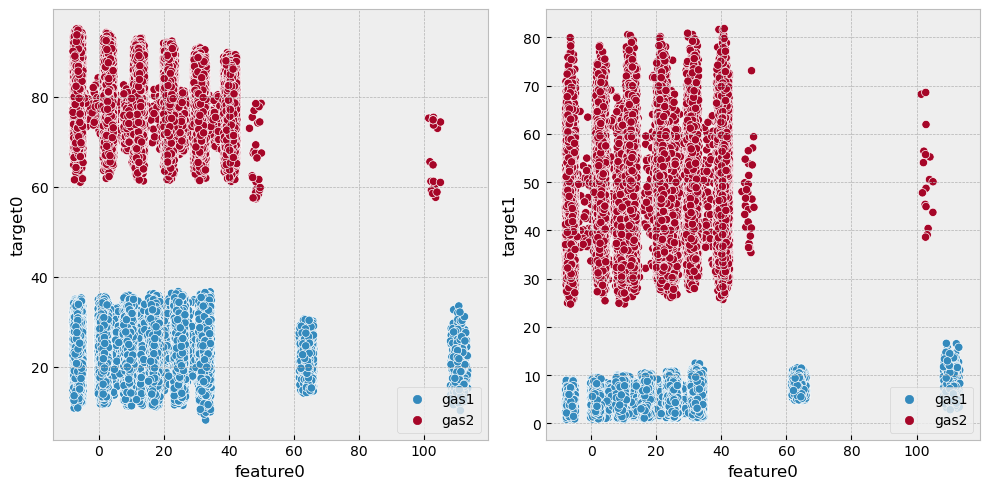

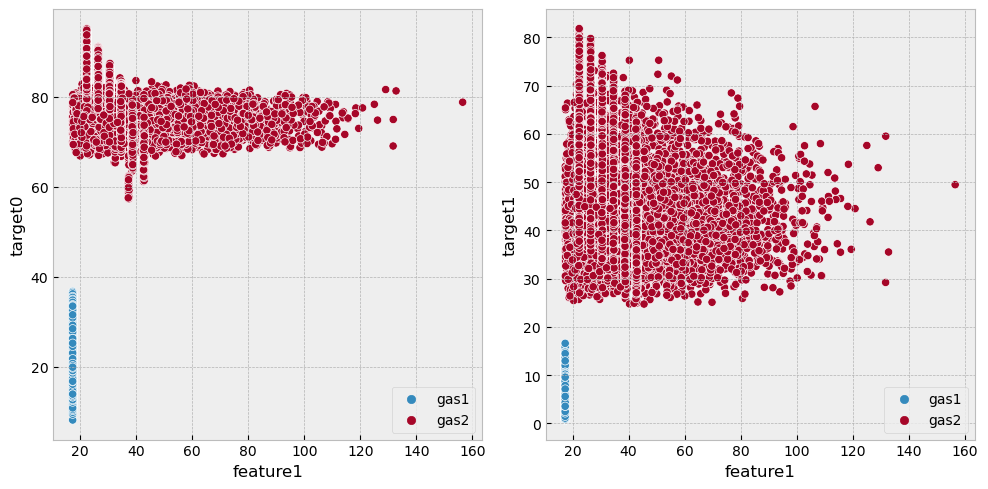

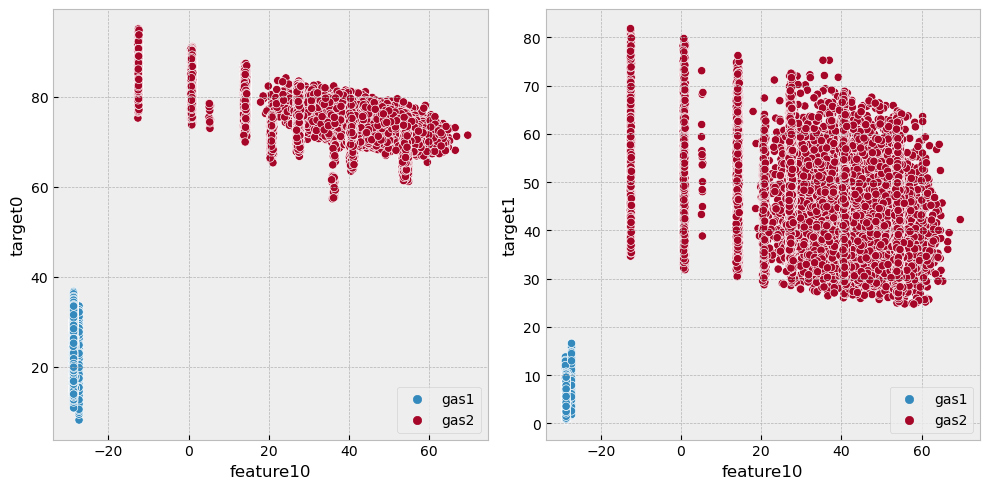

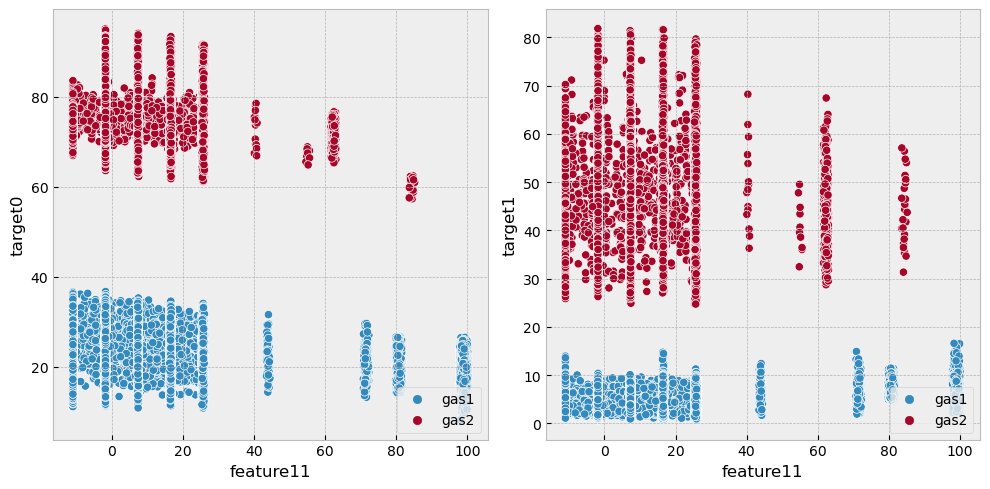

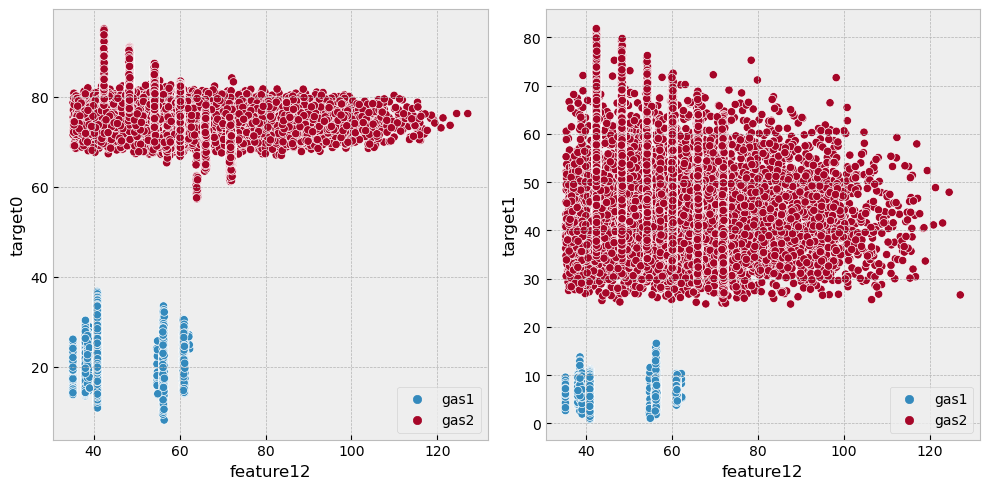

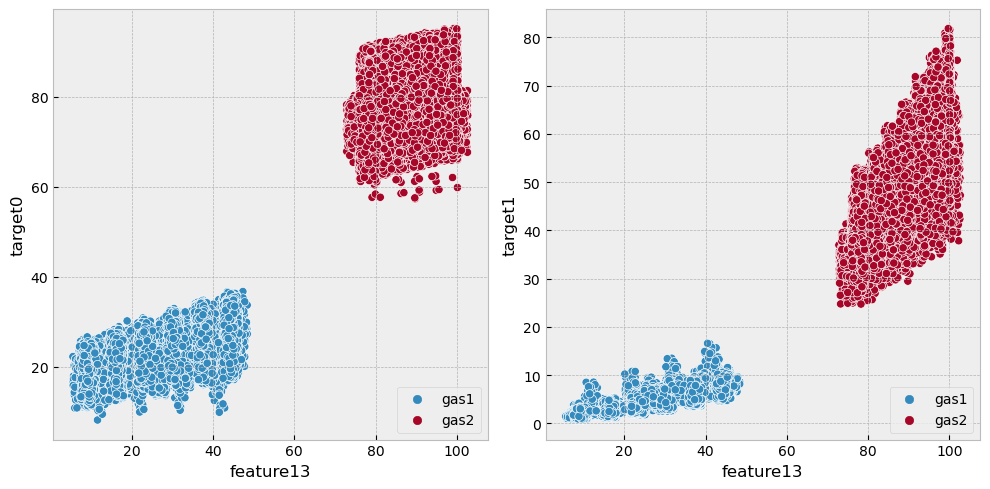

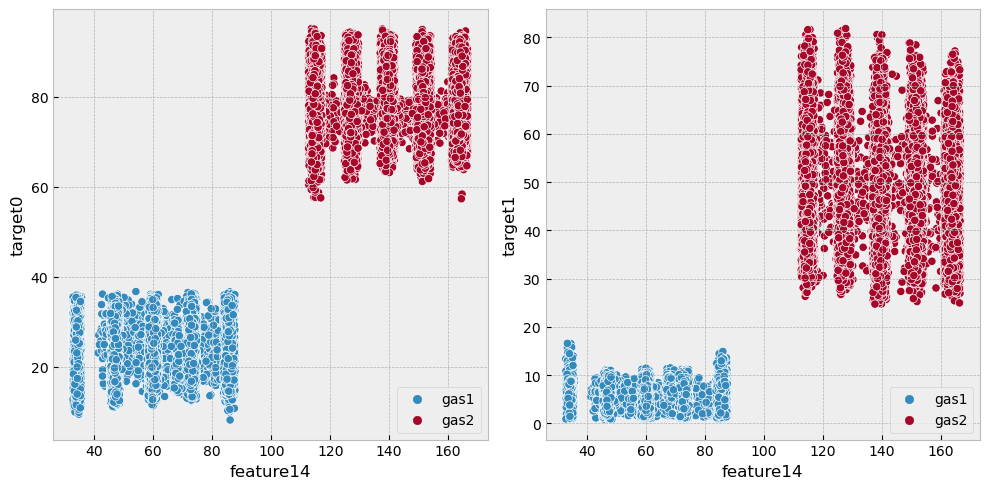

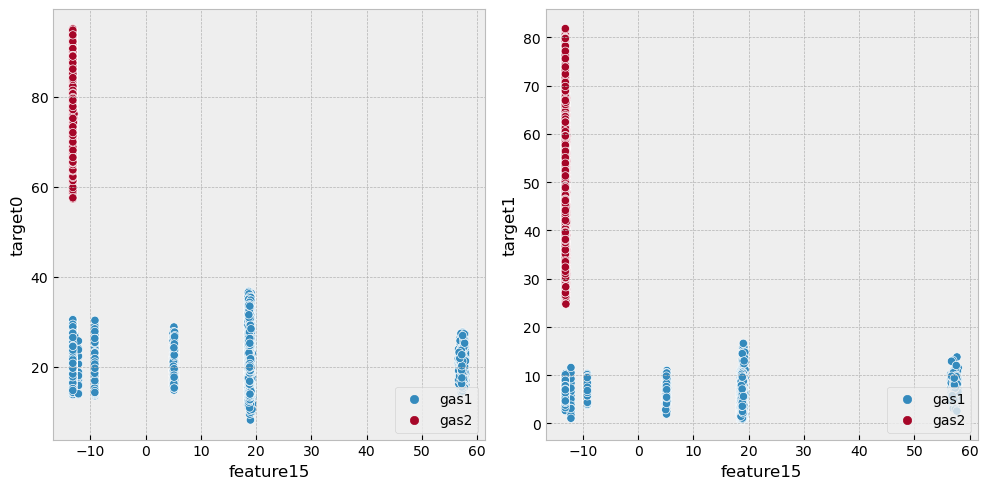

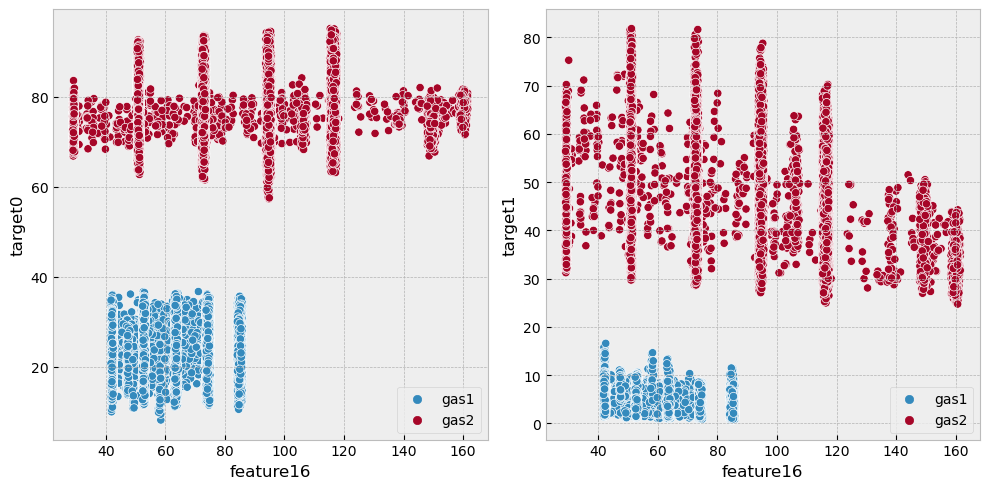

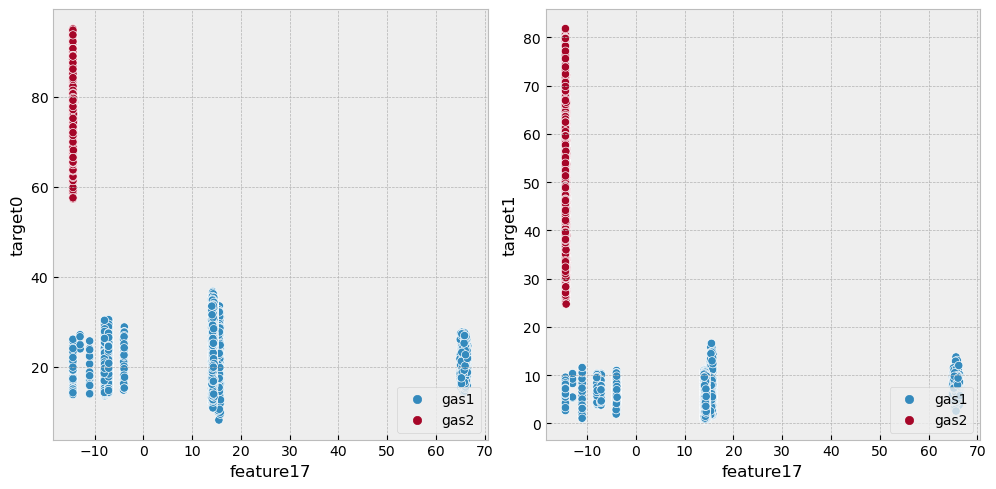

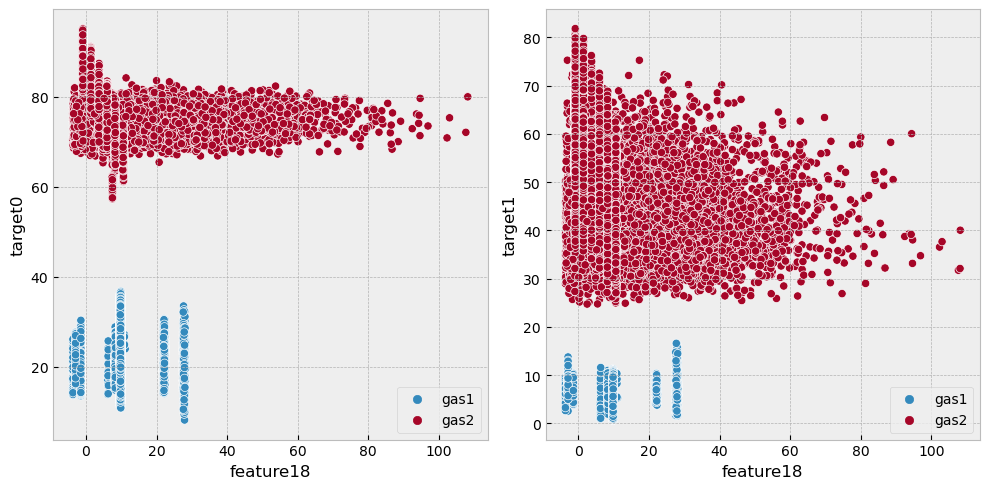

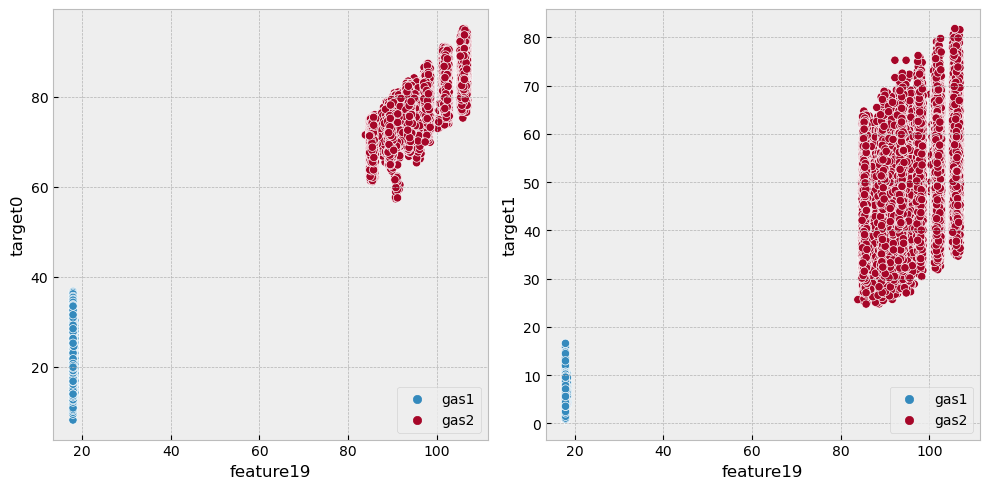

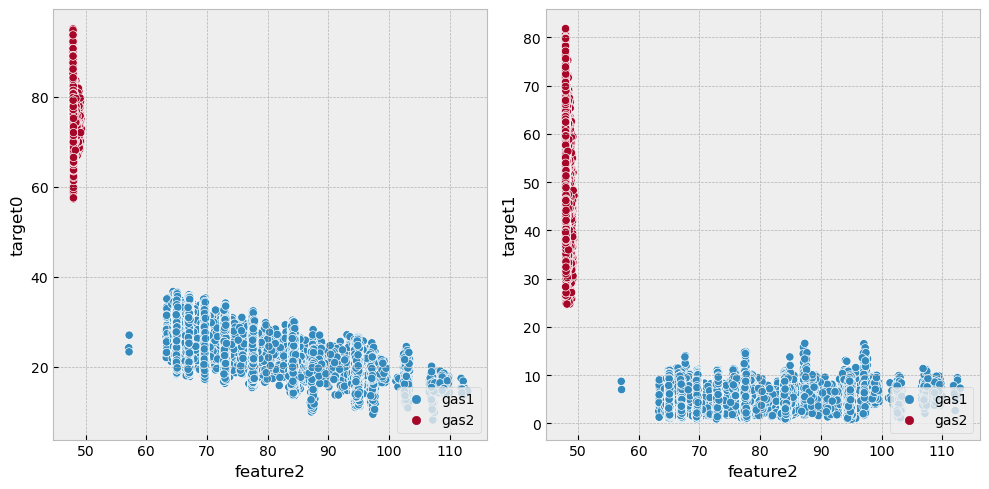

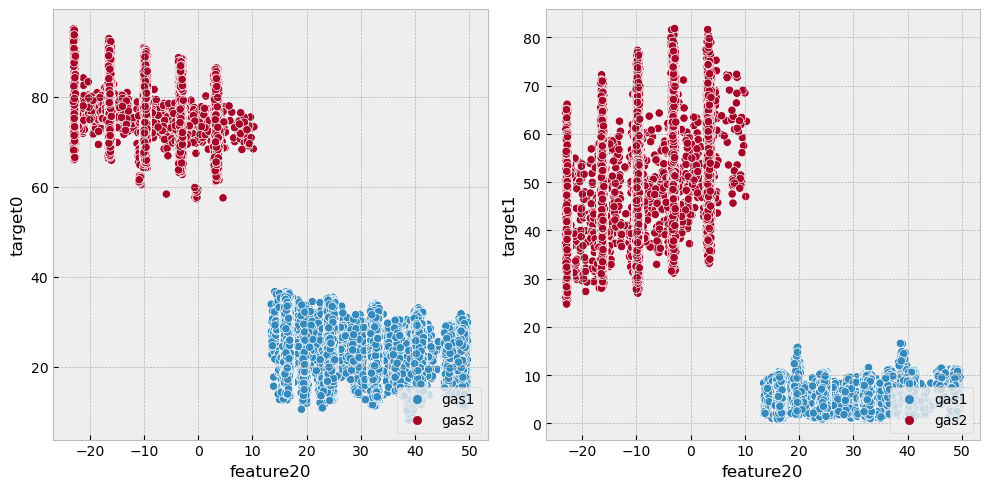

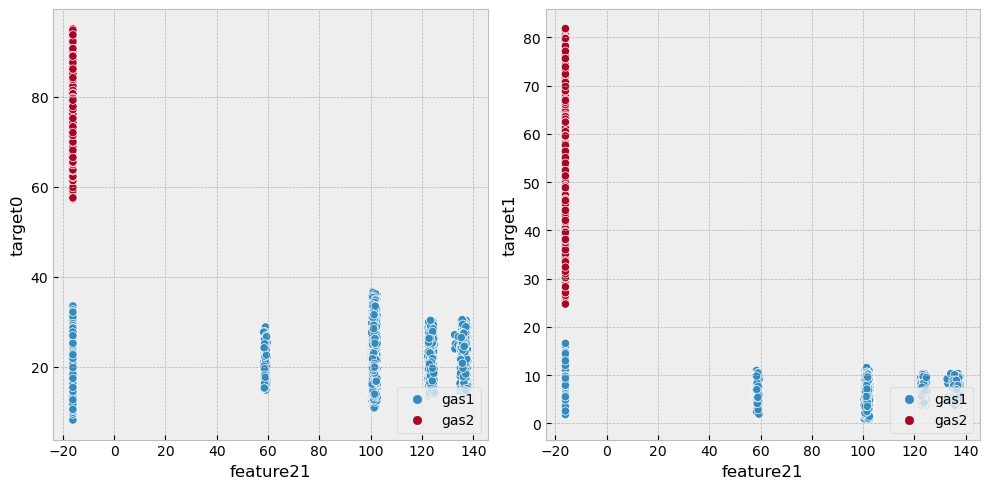

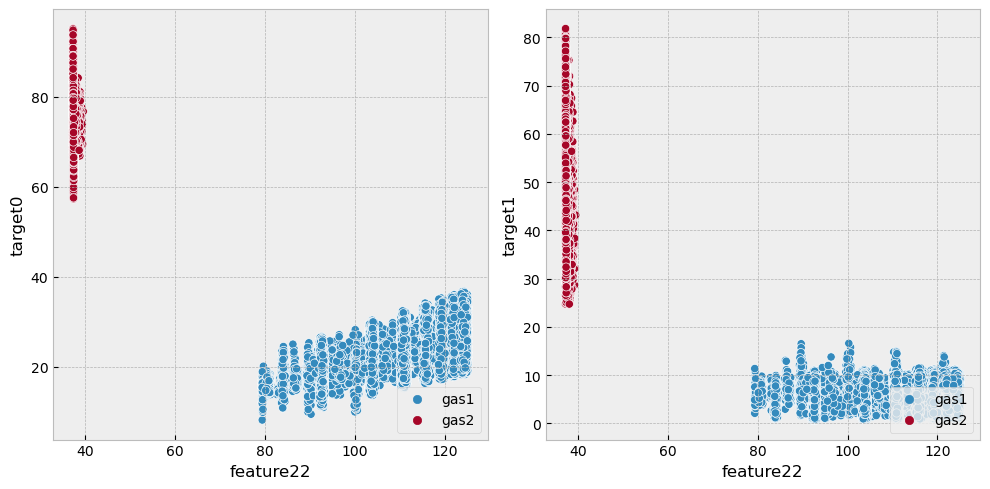

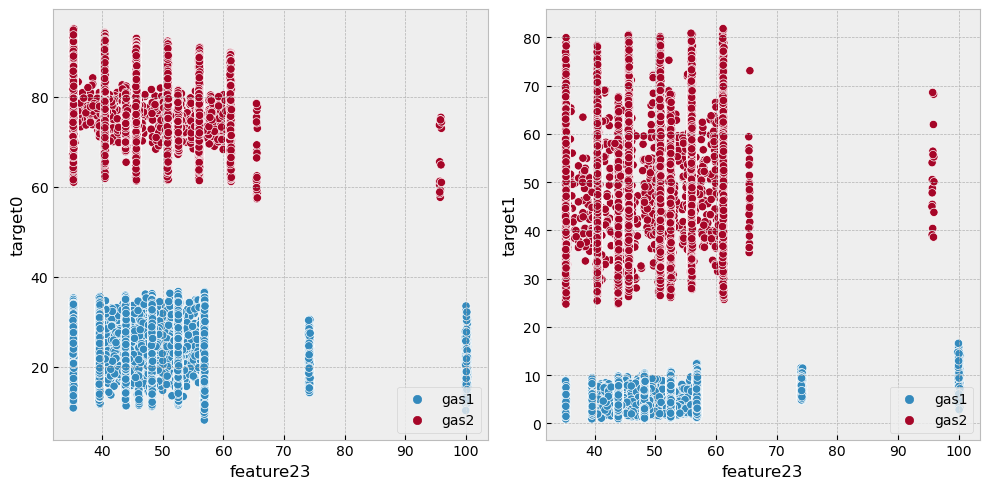

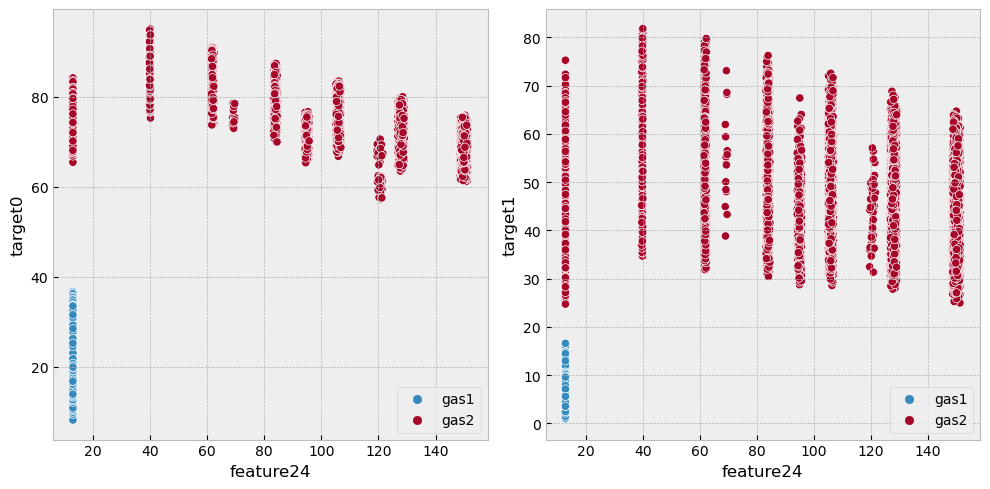

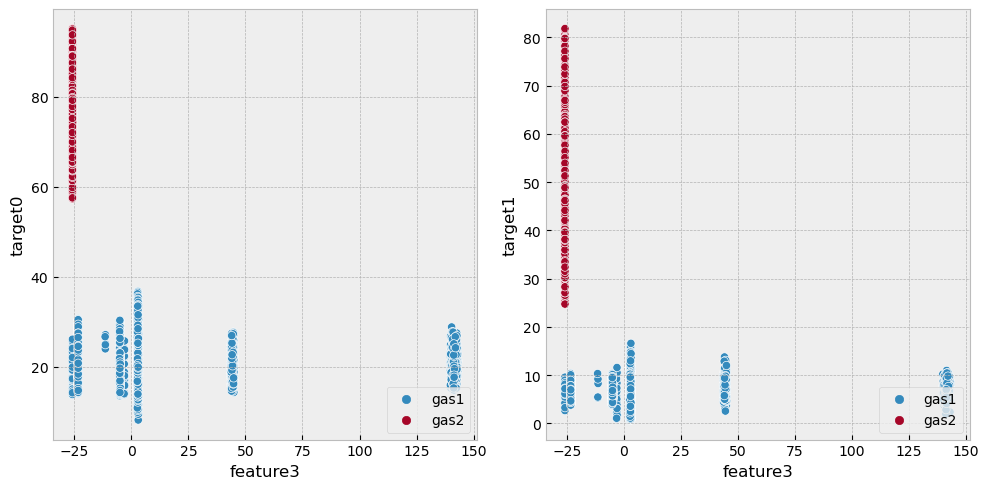

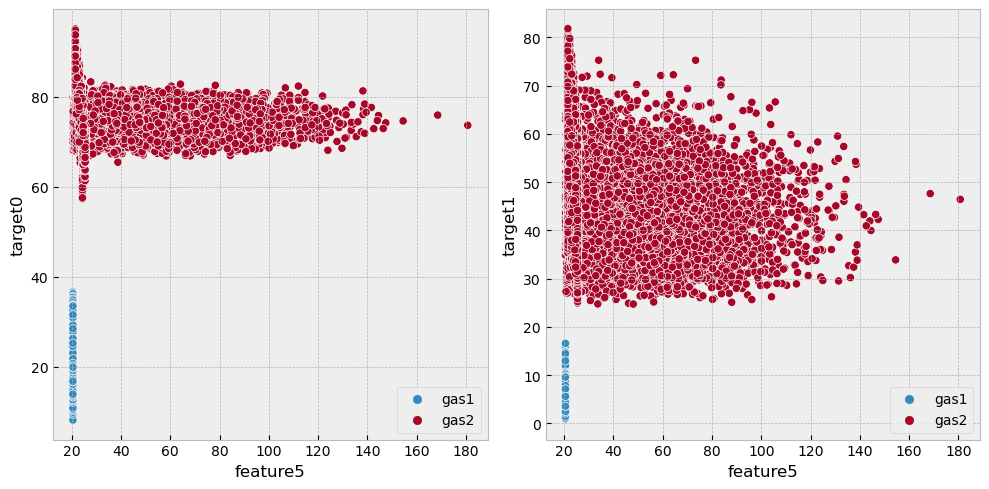

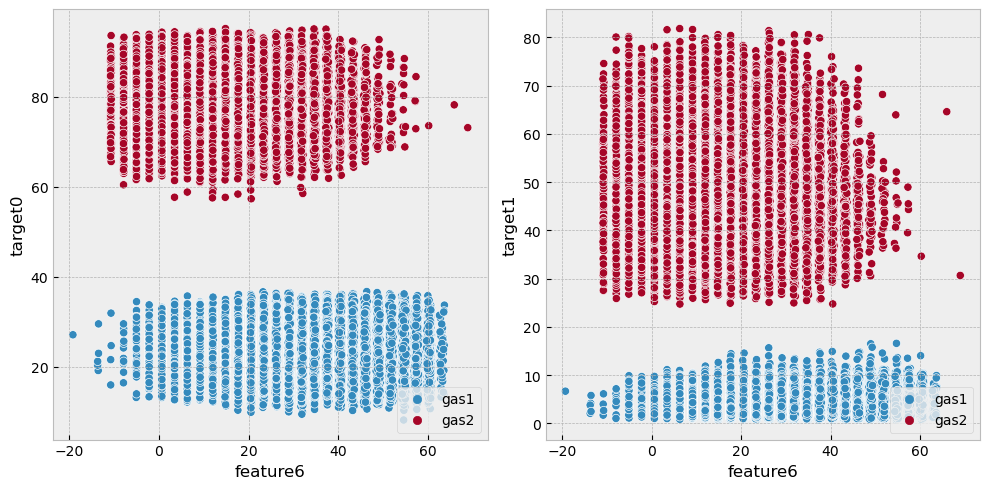

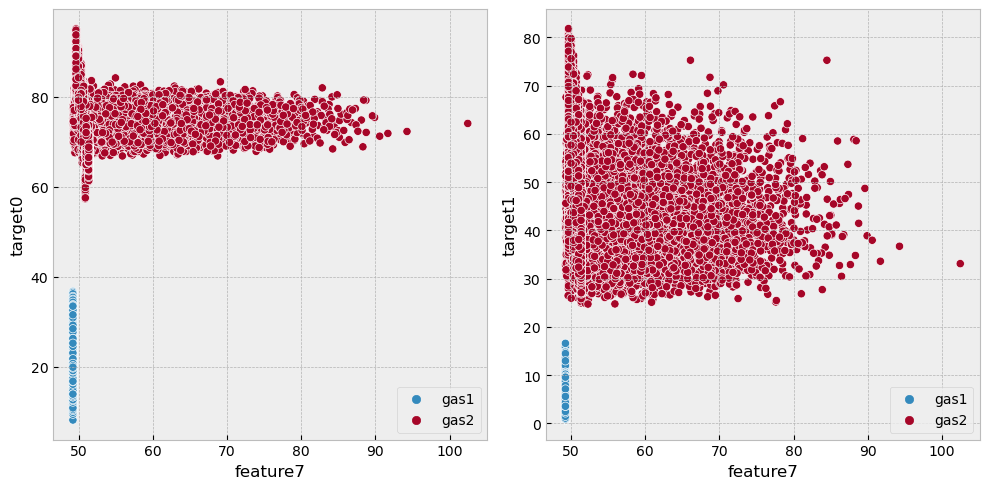

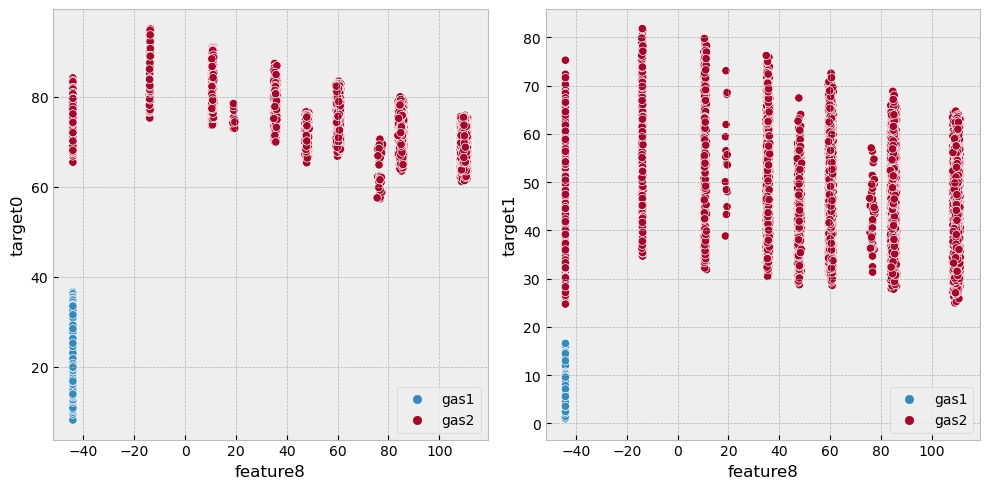

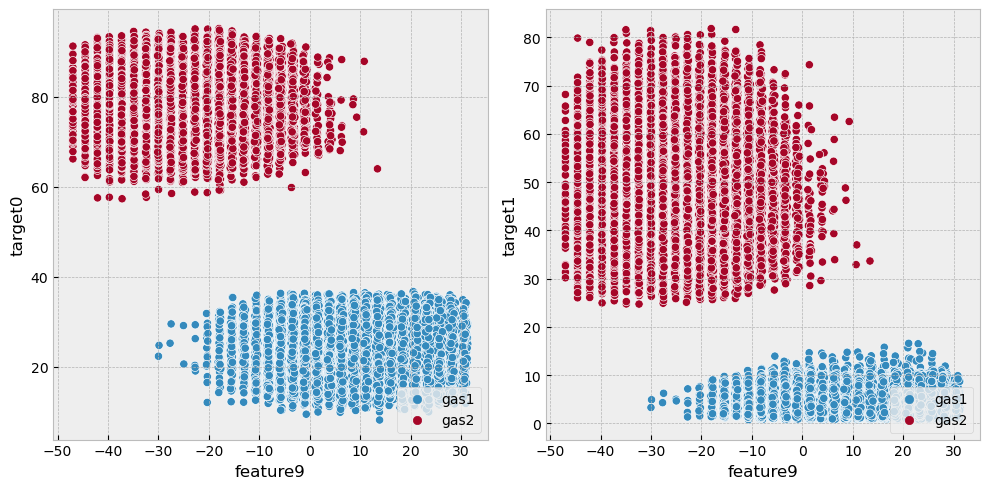

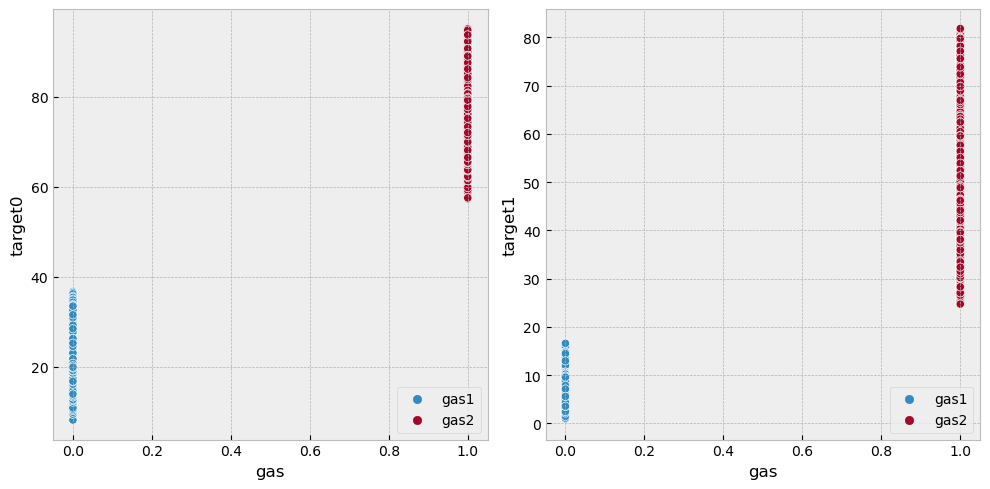

In [13]:
for feature in FTS:
    fig, axes = plt.subplots(1, len(TARGETS), figsize=(10, 5))
    for i, target in enumerate(TARGETS):
        ax = axes[i]
        sns.scatterplot(x=feature, y=target, data=train, hue='feature4', ax=ax)
        ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


Есть смысл разделять модели не только по таргетам, но и по типу газа.
Более того, можно заметить, что некоторые фичи, в зависимости от типа газа, имеют очень маленькую дисперсию по сравнению с остальными фичами и таргетом. Поэтому, я считаю, что их можно удалить.
для gas1 это: 8, 7, 5, 24, 19, 10, 1; для gas2: 15, 17, 2, 21, 22, 3.

In [11]:
group_lists = {}
statistics = train.groupby('feature4').describe()
for index, row in statistics.iterrows():
    group_name = index
    var_list = []
    
    for col in statistics.loc[index].index:
        if col[1] == 'std' and statistics.loc[index][col] < 1:
            var_list.append(col[0])
    
    group_lists[group_name] = var_list
print('\033[1mSTD < 1\033[0m')
for group_name, var_list in group_lists.items():
    print()
    print(f"Group: {group_name}")
    print(var_list)

STD < 1

Group: gas1
['feature1', 'feature5', 'feature7', 'feature8', 'feature10', 'feature19', 'feature24', 'gas']

Group: gas2
['feature2', 'feature3', 'feature15', 'feature17', 'feature21', 'feature22', 'gas']


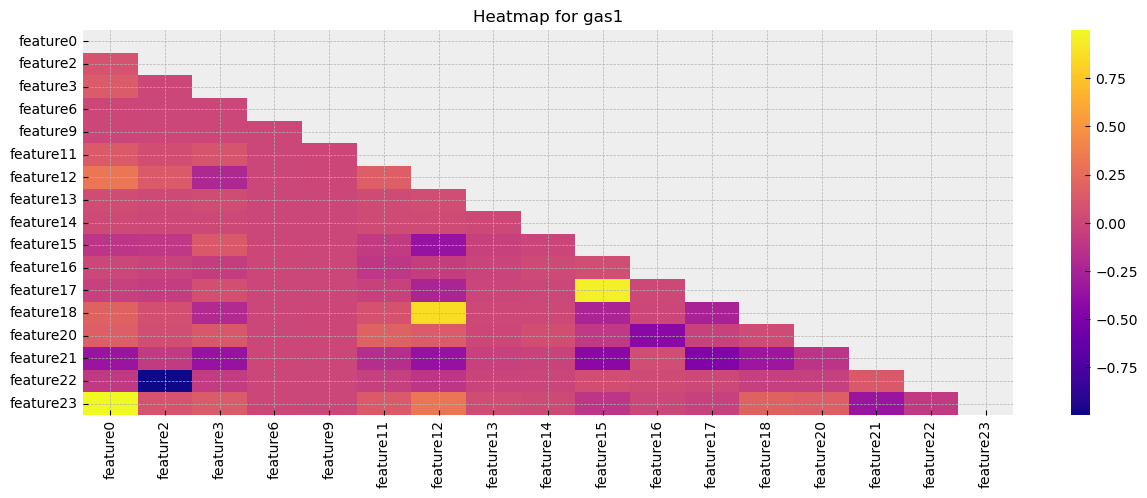

VIF > 7 for gas1 
feature0, feature2, feature12, feature15, feature17, feature18, feature22, feature23


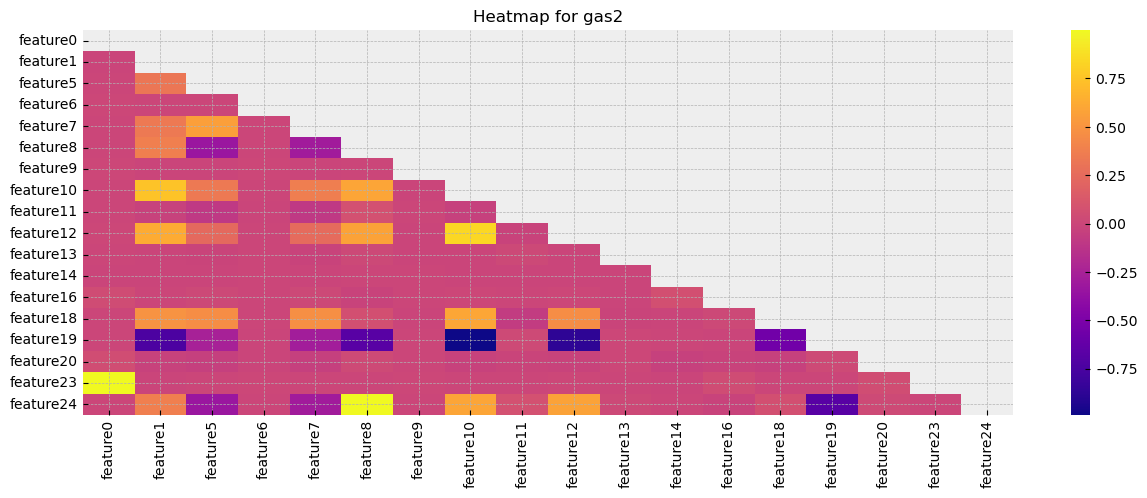

VIF > 7 for gas2 
feature0, feature8, feature10, feature12, feature19, feature23, feature24


In [12]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
big_VIFs = {}
gas_dfs = {}

# Создание новых датафреймов для каждого типа газа
for group_name, var_list in group_lists.items():
    gas_df = train[train['feature4'] == group_name].copy()
    gas_df.drop(var_list, axis=1, inplace=True)
    gas_df.drop('feature4', axis=1, inplace=True)
    gas_dfs[group_name] = gas_df

for group_name, gas_df in gas_dfs.items():
    data = gas_df.filter(like="feature").select_dtypes(include='number')
    mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    plt.figure(figsize=(15, 5))
    sns.heatmap(data.corr(), mask=mask, cmap='plasma')
    plt.title(f"Heatmap for {group_name}")
    plt.show()
    
    data_with_constant = sm.add_constant(data)
    # Вычисляем значения VIF для каждой переменной
    vif = pd.DataFrame()
    vif['Feature'] = data.columns
    vif["VIF"] = [variance_inflation_factor(data_with_constant.values, i) for i in range(1, data_with_constant.shape[1])]
    print('\033[1mVIF > 7 for', group_name, '\033[0m')
    big_VIF = vif.loc[vif['VIF'] > 7]
    big_VIFs[group_name] = big_VIF
    print('\033[1m' + ', '.join(big_VIF['Feature'].tolist()) + '\033[0m')

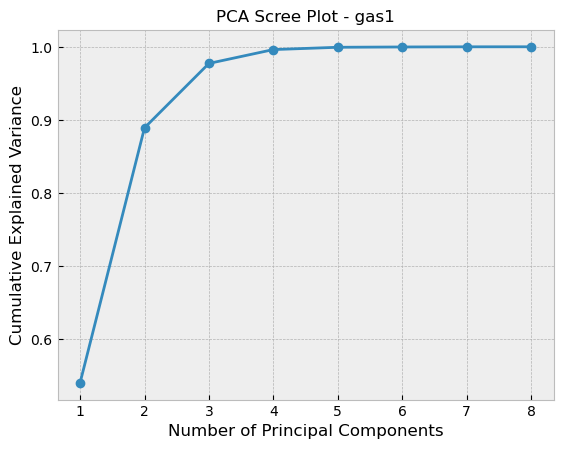

Number of significant principal components: 3


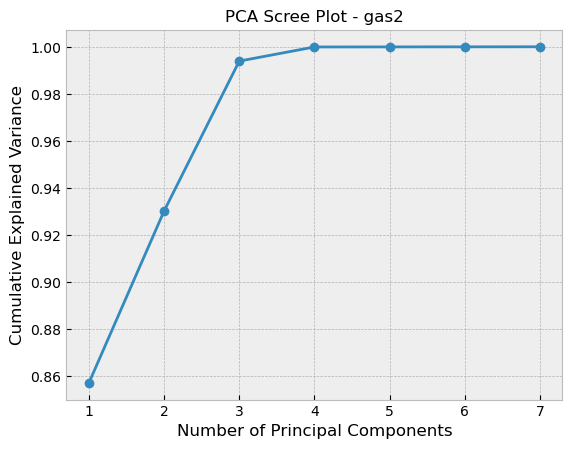

Number of significant principal components: 3


In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

for group_name, gas_df in gas_dfs.items():
    # Отбор переменных с высоким VIF
    selected_vars = [var for var in gas_df.columns if var in big_VIFs[group_name]['Feature'].tolist()]
    selected_df = gas_df[selected_vars]
    
    pca = PCA()
    pca.fit(selected_df)
    
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'PCA Scree Plot - {group_name}')
    plt.show()
    
    explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.argmax(explained_variance_ratio_cumsum >= 0.95) + 1
    print(f'Number of significant principal components: {num_components}')
    
    pca_features = pca.transform(selected_df)[:, :num_components]
    
    # Добавление признаков PCA в gas_df
    for i in range(num_components):
        gas_df[f'PCA_VIF_{i+1}'] = pca_features[:, i]
    
    gas_dfs[group_name] = gas_dfs[group_name].drop(selected_vars, axis=1)

/tmp/ipykernel_32/1169283972.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X.columns, rotation=90)


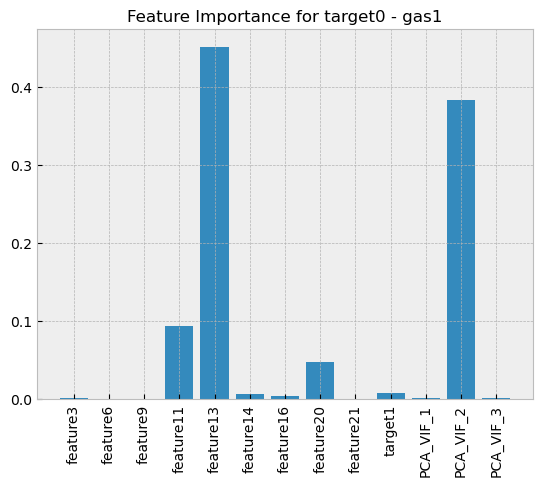

Selected features for target0 - gas1: ['feature13', 'PCA_VIF_2']


/tmp/ipykernel_32/1169283972.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X.columns, rotation=90)


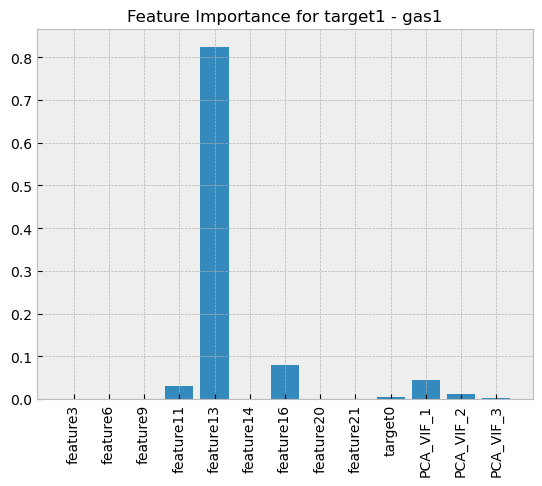

Selected features for target1 - gas1: ['feature13']


/tmp/ipykernel_32/1169283972.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X.columns, rotation=90)


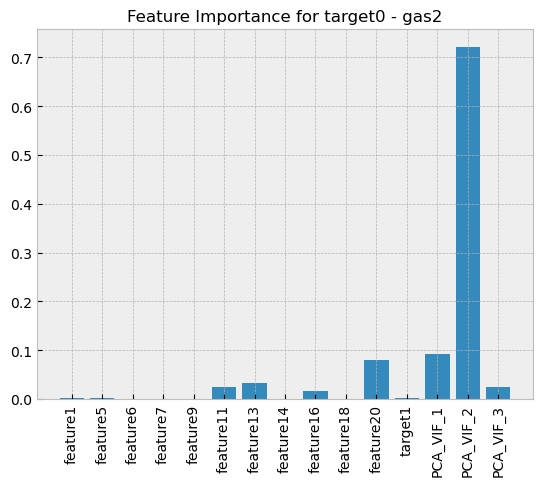

Selected features for target0 - gas2: ['PCA_VIF_2']


/tmp/ipykernel_32/1169283972.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X.columns, rotation=90)


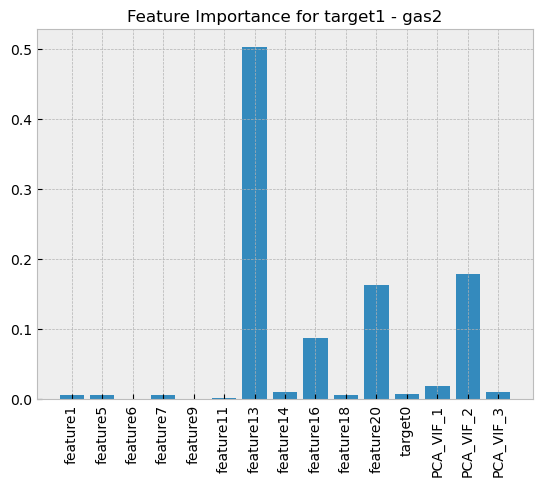

Selected features for target1 - gas2: ['feature13', 'feature20', 'PCA_VIF_2']


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

importance_features = {}

for group_name, gas_df in gas_dfs.items():
    target_vars = [col for col in gas_df.filter(like='target').columns]
    importance_features[group_name] = {}
    
    for var in target_vars:
        X = gas_df.drop(columns=[var])
        y = gas_df[var]
        
        lr = LinearRegression()
        lr.fit(X, y)
        
        rf = RandomForestRegressor()
        rf.fit(X, y)
        importances = rf.feature_importances_
        
        fig, ax = plt.subplots()
        ax.bar(X.columns, importances)
        ax.set_xticklabels(X.columns, rotation=90)
        ax.set_title(f'Feature Importance for {var} - {group_name}')
        plt.show()
        
        # Get feature names with importance greater than 0.5
        selected_features = X.columns[importances > 0.1]
        importance_features[group_name][var] = selected_features.tolist()
        print(f'Selected features for {var} - {group_name}: {selected_features.tolist()}')



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Learning rate set to 0.5
0:	learn: 2.8718667	total: 70.3ms	remaining: 6.96s
1:	learn: 1.8463261	total: 84.3ms	remaining: 4.13s
2:	learn: 1.2773501	total: 96.5ms	remaining: 3.12s
3:	learn: 1.0157389	total: 110ms	remaining: 2.65s
4:	learn: 0.8592741	total: 124ms	remaining: 2.35s
5:	learn: 0.7499474	total: 136ms	remaining: 2.13s
6:	learn: 0.6902951	total: 148ms	remaining: 1.96s
7:	learn: 0.6347356	total: 162ms	remaining: 1.86s
8:	learn: 0.5980727	total: 174ms	remaining: 1.76s
9:	learn: 0.5639021	total: 188ms	remaining: 1.69s
10:	learn: 0.5440602	total: 200ms	remaining: 1.61s
11:	learn: 0.5100079	total: 213ms	remaining: 1.56s
12:	learn: 0.4929654	total: 225ms	remaining: 1.5s
13:	learn: 0.4767940	total: 238ms	remaining: 1.46s
14:	learn: 0.4598606	total: 250ms	remaining: 1.42s
15:	learn: 0.4345132	total: 263ms	remaining: 1.38s
16:	learn: 0.4180368	total: 275ms	remaining: 1.34s
17:	learn: 0.4097184	total: 285ms	remaining: 1.3s
18:	learn: 0.3955629	total: 298ms	remaining: 1.27s
19:	learn: 0.38

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Learning rate set to 0.5
0:	learn: 1.2842216	total: 18ms	remaining: 1.78s
1:	learn: 0.7852130	total: 31.7ms	remaining: 1.55s
2:	learn: 0.5246694	total: 45.2ms	remaining: 1.46s
3:	learn: 0.4025538	total: 57.4ms	remaining: 1.38s
4:	learn: 0.3268444	total: 70.4ms	remaining: 1.34s
5:	learn: 0.2880215	total: 82.6ms	remaining: 1.29s
6:	learn: 0.2649382	total: 96.1ms	remaining: 1.28s
7:	learn: 0.2504661	total: 109ms	remaining: 1.25s
8:	learn: 0.2372010	total: 121ms	remaining: 1.22s
9:	learn: 0.2315019	total: 133ms	remaining: 1.2s
10:	learn: 0.2247967	total: 147ms	remaining: 1.19s
11:	learn: 0.2165601	total: 159ms	remaining: 1.17s
12:	learn: 0.2087423	total: 174ms	remaining: 1.16s
13:	learn: 0.2044153	total: 187ms	remaining: 1.15s
14:	learn: 0.1919952	total: 200ms	remaining: 1.13s
15:	learn: 0.1874893	total: 214ms	remaining: 1.12s
16:	learn: 0.1840218	total: 226ms	remaining: 1.1s
17:	learn: 0.1788943	total: 237ms	remaining: 1.08s
18:	learn: 0.1687589	total: 251ms	remaining: 1.07s
19:	learn: 0.

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Learning rate set to 0.5
0:	learn: 3.7080746	total: 11.8ms	remaining: 1.17s
1:	learn: 2.5183547	total: 22.6ms	remaining: 1.11s
2:	learn: 1.8647052	total: 33.3ms	remaining: 1.07s
3:	learn: 1.4764146	total: 44.5ms	remaining: 1.07s
4:	learn: 1.2469081	total: 53.1ms	remaining: 1.01s
5:	learn: 1.0846717	total: 62.7ms	remaining: 982ms
6:	learn: 0.9956565	total: 71.3ms	remaining: 947ms
7:	learn: 0.9415513	total: 80.4ms	remaining: 925ms
8:	learn: 0.8814204	total: 91.6ms	remaining: 926ms
9:	learn: 0.8383087	total: 102ms	remaining: 918ms
10:	learn: 0.7973704	total: 112ms	remaining: 907ms
11:	learn: 0.7699331	total: 122ms	remaining: 895ms
12:	learn: 0.7476429	total: 132ms	remaining: 880ms
13:	learn: 0.7281750	total: 141ms	remaining: 864ms
14:	learn: 0.7007184	total: 150ms	remaining: 850ms
15:	learn: 0.6840093	total: 160ms	remaining: 838ms
16:	learn: 0.6722256	total: 169ms	remaining: 825ms
17:	learn: 0.6598016	total: 181ms	remaining: 823ms
18:	learn: 0.6366107	total: 192ms	remaining: 817ms
19:	lea

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Learning rate set to 0.5
0:	learn: 5.5435889	total: 11.6ms	remaining: 1.15s
1:	learn: 3.6725730	total: 23.1ms	remaining: 1.13s
2:	learn: 2.6493815	total: 34.8ms	remaining: 1.12s
3:	learn: 2.0714385	total: 47.5ms	remaining: 1.14s
4:	learn: 1.7513929	total: 57.4ms	remaining: 1.09s
5:	learn: 1.5177133	total: 66.5ms	remaining: 1.04s
6:	learn: 1.3695458	total: 76.1ms	remaining: 1.01s
7:	learn: 1.2793320	total: 84.9ms	remaining: 977ms
8:	learn: 1.2152658	total: 93.4ms	remaining: 944ms
9:	learn: 1.1585188	total: 103ms	remaining: 931ms
10:	learn: 1.0920043	total: 114ms	remaining: 922ms
11:	learn: 1.0393123	total: 124ms	remaining: 907ms
12:	learn: 1.0133662	total: 133ms	remaining: 889ms
13:	learn: 0.9510933	total: 143ms	remaining: 880ms
14:	learn: 0.9227045	total: 153ms	remaining: 865ms
15:	learn: 0.9005391	total: 162ms	remaining: 849ms
16:	learn: 0.8575813	total: 171ms	remaining: 835ms
17:	learn: 0.8411712	total: 183ms	remaining: 832ms
18:	learn: 0.8146804	total: 194ms	remaining: 825ms
19:	lea

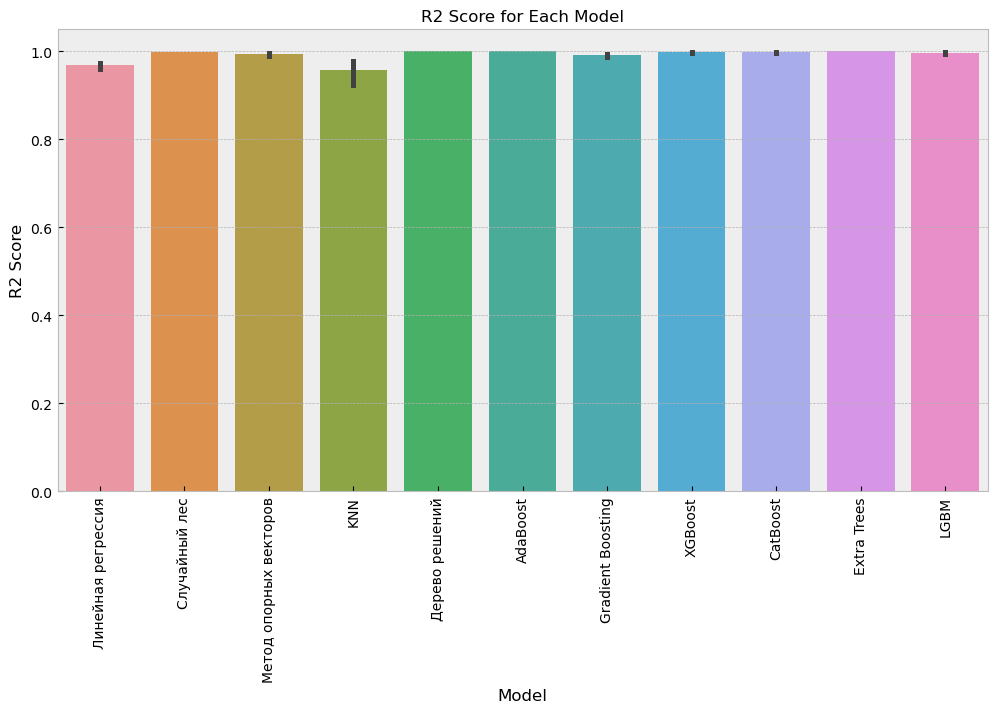

Best Models:
       Model Name  R2 Score
0     Extra Trees  1.000000
1  Дерево решений  1.000000
2        AdaBoost  0.999995


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score

reg1 = LinearRegression()
reg2 = RandomForestRegressor(n_jobs=-1)
reg3 = SVR()
reg4 = KNeighborsRegressor()
reg5 = DecisionTreeRegressor()
reg6 = AdaBoostRegressor(base_estimator=reg5)
reg7 = GradientBoostingRegressor()
reg8 = XGBRegressor(booster='gbtree', learning_rate=0.1, max_depth=5, n_estimators=180)
reg9 = CatBoostRegressor(iterations=100)
reg10 = ExtraTreesRegressor()
reg11 = LGBMRegressor(learning_rate=1)

labels = ['Линейная регрессия', 'Случайный лес', 'Метод опорных векторов', 'KNN', 'Дерево решений', 
          'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'Extra Trees', 'LGBM']

roc_scores = []
model_names = []

for group_name, gas_df in gas_dfs.items():
    target_vars = [col for col in gas_df.filter(like='target').columns]
    
    for var in target_vars:
        X = gas_df.drop(columns=[var])
        y = gas_df[var]
        
        for reg, lab in zip([reg1, reg2, reg3, reg4, reg5, reg6, reg7, reg8, reg9, reg10, reg11], labels):
            reg.fit(X, y)
            y_pred = reg.predict(X)
            roc_score = r2_score(y, y_pred)
            roc_scores.append(roc_score)
            model_names.append(lab)
            
roc_scores_df = pd.DataFrame({"R2 Score": roc_scores, "Model Name": model_names})

plt.figure(figsize=(12, 6))
sns.barplot(x="Model Name", y="R2 Score", data=roc_scores_df)
plt.title("R2 Score for Each Model")
plt.xlabel("Model")
plt.ylabel("R2 Score")
plt.xticks(rotation=90)
plt.show()

best_models = roc_scores_df.groupby("Model Name").mean().sort_values(by="R2 Score", ascending=False).head(3)
best_models = best_models.reset_index()

print("Best Models:")
print(best_models)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Learning rate set to 0.5
0:	learn: 2.8739306	total: 68.7ms	remaining: 6.8s
1:	learn: 1.8604080	total: 81ms	remaining: 3.97s
2:	learn: 1.2968208	total: 92.3ms	remaining: 2.98s
3:	learn: 1.0249479	total: 104ms	remaining: 2.51s
4:	learn: 0.8843461	total: 115ms	remaining: 2.18s
5:	learn: 0.7844469	total: 126ms	remaining: 1.97s
6:	learn: 0.7149665	total: 136ms	remaining: 1.81s
7:	learn: 0.6657220	total: 146ms	remaining: 1.68s
8:	learn: 0.6342042	total: 156ms	remaining: 1.58s
9:	learn: 0.6120737	total: 167ms	remaining: 1.5s
10:	learn: 0.5810096	total: 177ms	remaining: 1.43s
11:	learn: 0.5641311	total: 186ms	remaining: 1.37s
12:	learn: 0.5266812	total: 197ms	remaining: 1.32s
13:	learn: 0.5101632	total: 207ms	remaining: 1.27s
14:	learn: 0.4868479	total: 217ms	remaining: 1.23s
15:	learn: 0.4587373	total: 228ms	remaining: 1.19s
16:	learn: 0.4408937	total: 238ms	remaining: 1.16s
17:	learn: 0.4271491	total: 248ms	remaining: 1.13s
18:	learn: 0.4136162	total: 259ms	remaining: 1.1s
19:	learn: 0.39623

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Learning rate set to 0.5
0:	learn: 1.2791942	total: 13.4ms	remaining: 1.32s
1:	learn: 0.7843553	total: 24.5ms	remaining: 1.2s
2:	learn: 0.5345755	total: 35.3ms	remaining: 1.14s
3:	learn: 0.4083262	total: 45.3ms	remaining: 1.09s
4:	learn: 0.3238548	total: 56.2ms	remaining: 1.07s
5:	learn: 0.2821650	total: 65.9ms	remaining: 1.03s
6:	learn: 0.2608395	total: 75.9ms	remaining: 1.01s
7:	learn: 0.2416142	total: 85.7ms	remaining: 986ms
8:	learn: 0.2291252	total: 95ms	remaining: 961ms
9:	learn: 0.2234078	total: 104ms	remaining: 939ms
10:	learn: 0.2081979	total: 114ms	remaining: 923ms
11:	learn: 0.1958810	total: 124ms	remaining: 909ms
12:	learn: 0.1900683	total: 135ms	remaining: 902ms
13:	learn: 0.1812381	total: 146ms	remaining: 896ms
14:	learn: 0.1759554	total: 155ms	remaining: 877ms
15:	learn: 0.1696333	total: 166ms	remaining: 871ms
16:	learn: 0.1658656	total: 178ms	remaining: 869ms
17:	learn: 0.1623021	total: 188ms	remaining: 855ms
18:	learn: 0.1586438	total: 198ms	remaining: 846ms
19:	learn:

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Learning rate set to 0.495545
0:	learn: 3.7233448	total: 11.8ms	remaining: 1.17s
1:	learn: 2.5508192	total: 21.6ms	remaining: 1.06s
2:	learn: 1.8735528	total: 31.4ms	remaining: 1.02s
3:	learn: 1.4905285	total: 41.6ms	remaining: 997ms
4:	learn: 1.2808068	total: 50.1ms	remaining: 952ms
5:	learn: 1.0980324	total: 60.4ms	remaining: 947ms
6:	learn: 0.9978841	total: 68.5ms	remaining: 910ms
7:	learn: 0.9310465	total: 76.5ms	remaining: 879ms
8:	learn: 0.8772557	total: 84.5ms	remaining: 855ms
9:	learn: 0.8522444	total: 92.3ms	remaining: 831ms
10:	learn: 0.8292368	total: 102ms	remaining: 824ms
11:	learn: 0.7857168	total: 112ms	remaining: 823ms
12:	learn: 0.7537265	total: 122ms	remaining: 815ms
13:	learn: 0.7413931	total: 130ms	remaining: 797ms
14:	learn: 0.7101993	total: 138ms	remaining: 784ms
15:	learn: 0.6921589	total: 147ms	remaining: 770ms
16:	learn: 0.6781791	total: 155ms	remaining: 759ms
17:	learn: 0.6655848	total: 163ms	remaining: 743ms
18:	learn: 0.6477043	total: 172ms	remaining: 733ms
1

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Learning rate set to 0.495545
0:	learn: 5.5779511	total: 13.6ms	remaining: 1.35s
1:	learn: 3.7189264	total: 24.9ms	remaining: 1.22s
2:	learn: 2.6616858	total: 33.2ms	remaining: 1.07s
3:	learn: 2.0886246	total: 42.2ms	remaining: 1.01s
4:	learn: 1.7582788	total: 50.2ms	remaining: 955ms
5:	learn: 1.5481230	total: 58.3ms	remaining: 913ms
6:	learn: 1.4111153	total: 67.1ms	remaining: 892ms
7:	learn: 1.3002392	total: 74.8ms	remaining: 860ms
8:	learn: 1.2216159	total: 83.1ms	remaining: 840ms
9:	learn: 1.1796802	total: 90.8ms	remaining: 818ms
10:	learn: 1.1351860	total: 99.5ms	remaining: 805ms
11:	learn: 1.0616365	total: 108ms	remaining: 795ms
12:	learn: 1.0144996	total: 117ms	remaining: 784ms
13:	learn: 0.9937557	total: 126ms	remaining: 772ms
14:	learn: 0.9674525	total: 134ms	remaining: 758ms
15:	learn: 0.9424374	total: 143ms	remaining: 749ms
16:	learn: 0.9100982	total: 151ms	remaining: 737ms
17:	learn: 0.8829706	total: 160ms	remaining: 727ms
18:	learn: 0.8731389	total: 168ms	remaining: 717ms


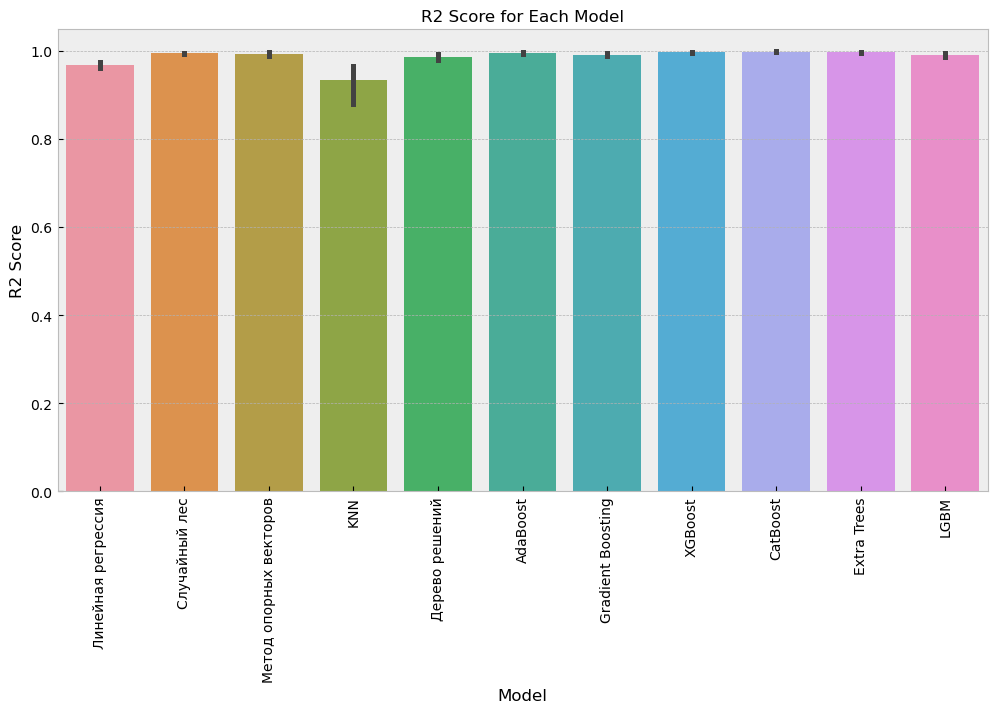

Best Models:
    Model Name  R2 Score
0     CatBoost  0.997513
1      XGBoost  0.996951
2  Extra Trees  0.996234


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

reg1 = LinearRegression()
reg2 = RandomForestRegressor(n_jobs=-1)
reg3 = SVR()
reg4 = KNeighborsRegressor()
reg5 = DecisionTreeRegressor()
reg6 = AdaBoostRegressor(base_estimator=reg5)
reg7 = GradientBoostingRegressor()
reg8 = XGBRegressor(booster='gbtree', learning_rate=0.1, max_depth=5, n_estimators=180)
reg9 = CatBoostRegressor(iterations=100)
reg10 = ExtraTreesRegressor()
reg11 = LGBMRegressor(learning_rate=1)

labels = ['Линейная регрессия', 'Случайный лес', 'Метод опорных векторов', 'KNN', 'Дерево решений', 
          'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'Extra Trees', 'LGBM']

roc_scores = []
model_names = []

for group_name, gas_df in gas_dfs.items():
    target_vars = [col for col in gas_df.filter(like='target').columns]
    
    for var in target_vars:
        X = gas_df.drop(columns=[var])
        y = gas_df[var]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        for reg, lab in zip([reg1, reg2, reg3, reg4, reg5, reg6, reg7, reg8, reg9, reg10, reg11], labels):
            reg.fit(X_train, y_train)
            y_pred = reg.predict(X_test)
            roc_score = r2_score(y_test, y_pred)
            roc_scores.append(roc_score)
            model_names.append(lab)
            
roc_scores_df = pd.DataFrame({"R2 Score": roc_scores, "Model Name": model_names})

plt.figure(figsize=(12, 6))
sns.barplot(x="Model Name", y="R2 Score", data=roc_scores_df)
plt.title("R2 Score for Each Model")
plt.xlabel("Model")
plt.ylabel("R2 Score")
plt.xticks(rotation=90)
plt.show()

best_models = roc_scores_df.groupby("Model Name").mean().sort_values(by="R2 Score", ascending=False).head(3)
best_models = best_models.reset_index()

print("Best Models:")
print(best_models)

In [21]:
best_models['Model Name'].tolist()

['CatBoost', 'XGBoost', 'Extra Trees']

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import VotingRegressor

# Создание списка моделей
models = [
    reg8,
#     reg9,
    reg10
]

# Создание списка для хранения объединенных моделей
ensemble_models = []

for group_name, gas_df in gas_dfs.items():
    target_vars = [col for col in gas_df.filter(like='target').columns]
    
    for var in target_vars:
        X = gas_df.drop(columns=[var])
        y = gas_df[var]
        
        # Разбиение на тренировочную и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Список для хранения предсказаний каждой модели
        y_preds = []
        
        # Грид-поиск для каждой модели
        best_models = []
        for model in models:
            if isinstance(model, type(reg9)):
                param_grid = {
                    'iterations': [100, 200, 300],
                    'learning_rate': [0.01, 0.1, 0.5],
                    'depth': [5, 10, 15]
                }
            elif isinstance(model, type(reg8)):
                param_grid = {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.01, 0.1, 0.5],
                    'max_depth': [5, 10, 15]
                }
            elif isinstance(model, type(reg10)):
                param_grid = {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [5, 10, 15],
                    'min_samples_split': [2, 5, 10]
                }
            else:
                param_grid = {}  # Добавьте сетку для остальных моделей
            
            grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_percentage_error', cv=5)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_models.append(best_model)
        
        # Обучение и оценка каждой модели
        for model in best_models:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mape_score = mean_absolute_percentage_error(y_test, y_pred)
            y_preds.append(y_pred)
            
            print(f'MAPE Score for {model.__class__.__name__} - {var} - {group_name}: {mape_score}')
        
        # Объединение моделей для данного газа и таргета
        ensemble_model = VotingRegressor(estimators=[(model.__class__.__name__, model) for model in best_models])
        ensemble_model.fit(X_train, y_train)
        ensemble_preds = ensemble_model.predict(X_test)
        ensemble_mape_score = mean_absolute_percentage_error(y_test, ensemble_preds)
        
        print(f'MAPE Score for Ensemble Model - {var} - {group_name}: {ensemble_mape_score}\n')
        
        # Сохранение объединенной модели
        ensemble_models.append(ensemble_model)
        
import joblib

# Сохранение каждой модели в отдельный файл
for i, model in enumerate(ensemble_models):
    filename = f'model_{i+1}.joblib'
    joblib.dump(model, filename)
    print(f"Модель {filename} сохранена.")

# Сохранение списка моделей в один файл
ensemble_filename = 'ensemble_models.joblib'
joblib.dump(ensemble_models, ensemble_filename)
print(f"Объединенные модели сохранены в файл {ensemble_filename}.")

MAPE Score for XGBRegressor - target0 - gas1: 0.0049300544278322
MAPE Score for ExtraTreesRegressor - target0 - gas1: 0.010810646604281446
MAPE Score for Ensemble Model - target0 - gas1: 0.006743512996868857

MAPE Score for XGBRegressor - target1 - gas1: 0.006706843600290308
MAPE Score for ExtraTreesRegressor - target1 - gas1: 0.01201227002524561
MAPE Score for Ensemble Model - target1 - gas1: 0.00802480082772474

MAPE Score for XGBRegressor - target0 - gas2: 0.002633181445509384
MAPE Score for ExtraTreesRegressor - target0 - gas2: 0.003912391990747115
MAPE Score for Ensemble Model - target0 - gas2: 0.00287389022274178

MAPE Score for XGBRegressor - target1 - gas2: 0.006696255534152982
MAPE Score for ExtraTreesRegressor - target1 - gas2: 0.012937248270655023
MAPE Score for Ensemble Model - target1 - gas2: 0.008639801956796006

Модель model_1.joblib сохранена.
Модель model_2.joblib сохранена.
Модель model_3.joblib сохранена.
Модель model_4.joblib сохранена.
Объединенные модели сохранены

In [17]:

loaded_models = []
for i in range(1, 5):
    filename = f'model_{i}.joblib'
    loaded_model = joblib.load(filename)
    loaded_models.append(loaded_model)

# Вывод архитектуры каждой модели
for i, model in enumerate(loaded_models):
    print(f"Архитектура модели {i+1}:")
    print(model)
    print()


Архитектура модели 1:
VotingRegressor(estimators=[('XGBRegressor',
                             XGBRegressor(base_score=None, booster='gbtree',
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_

In [28]:
loaded_model_names = ['target0_gas1', 'target1_gas1', 'target0_gas2', 'target1_gas2']
named_models = dict(zip(loaded_model_names, loaded_models))

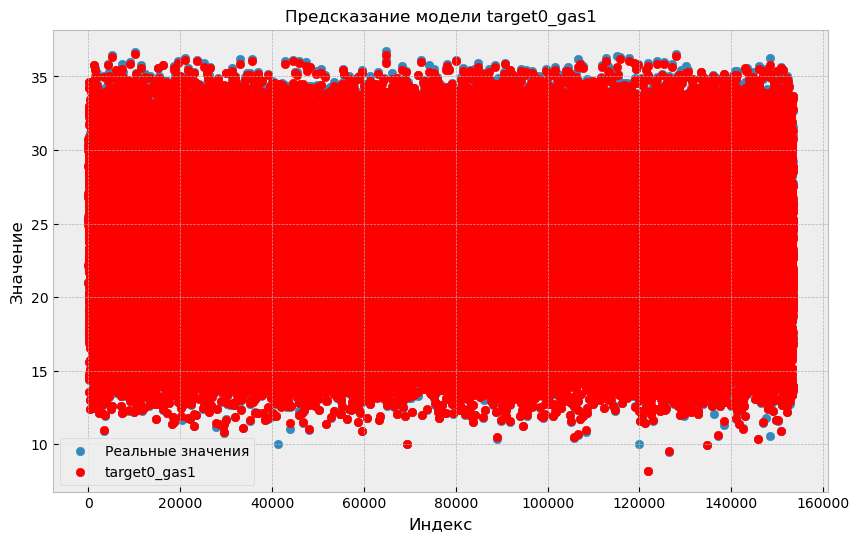

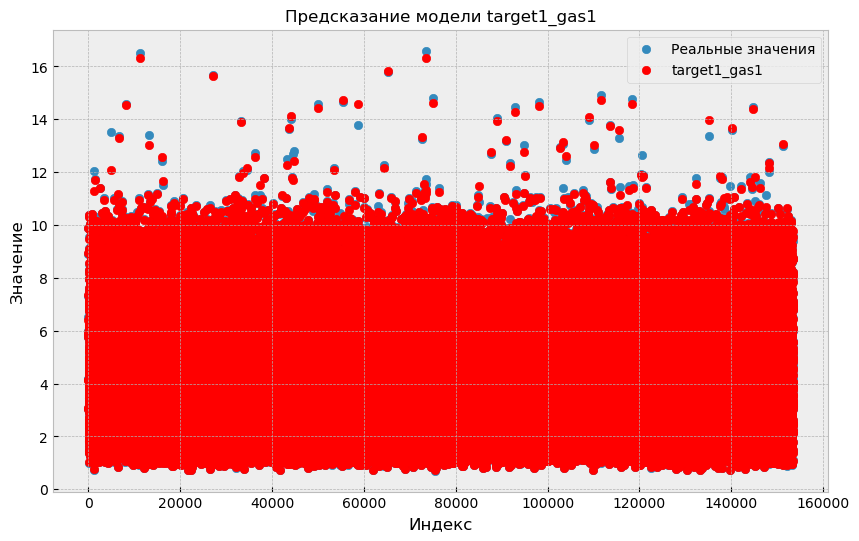

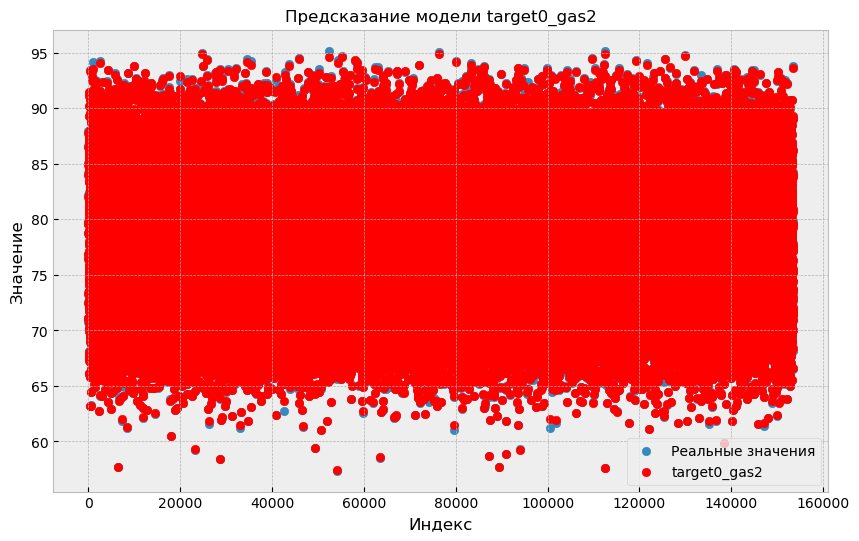

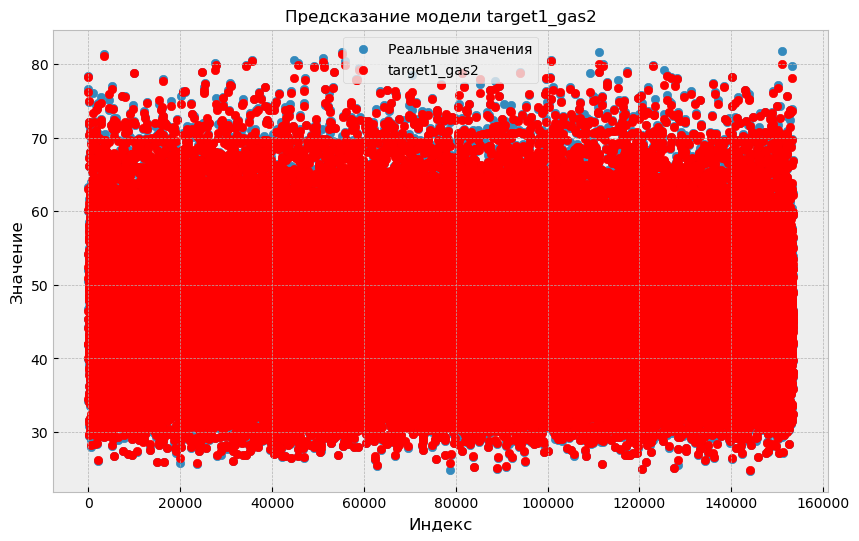

In [29]:
for group_name, gas_df in gas_dfs.items():
    target_vars = [col for col in gas_df.filter(like='target').columns]
    
    for var in target_vars:
        X = gas_df.drop(columns=[var])
        y = gas_df[var]
        
        # Получение предсказания выбранной модели
        model_name = f"{var}_{group_name}"
        model = named_models[model_name]
        y_pred = model.predict(X)
        
        # Визуализация предсказания
        plt.figure(figsize=(10, 6))
        plt.scatter(y.index, y, label='Реальные значения')
        plt.scatter(y.index, y_pred, label=model_name, color='red')
        plt.title(f"Предсказание модели {model_name}")
        plt.xlabel("Индекс")
        plt.ylabel("Значение")
        plt.legend()
        plt.show()


In [31]:
from sklearn.metrics import mean_absolute_percentage_error

for group_name, gas_df in gas_dfs.items():
    target_vars = [col for col in gas_df.filter(like='target').columns]
    
    for var in target_vars:
        X = gas_df.drop(columns=[var])
        y = gas_df[var]
        
        # Получение предсказания выбранной модели
        model_name = f"{var}_{group_name}"
        model = named_models[model_name]
        y_pred = model.predict(X)
        
        # Вычисление MAPE
        mape = mean_absolute_percentage_error(y, y_pred)
        mape_percentage = mape * 100
        
        print(f"MAPE для модели {model_name}: {mape_percentage}%")

MAPE для модели target0_gas1: 0.46377911621351714%
MAPE для модели target1_gas1: 0.5566585382362745%
MAPE для модели target0_gas2: 0.1512012716915708%
MAPE для модели target1_gas2: 0.49058470760062506%


# Простая модель

Построим простую модель со случайным разбиением на тренировочное и валидационное множества. Таргеты будем моделировать отдельно.

In [19]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(train[FTS], train[TARGETS], train_size=0.5, random_state=RS)

In [20]:
models = {}
tr_preds = []
val_preds = []

for tg in TARGETS:
    print(f"{tg}", "=" * 10)
    cb_model = CatBoostRegressor(max_depth=4, iterations=5000,
                                 early_stopping_rounds=20, objective="MAPE", verbose=200,
                                 random_state=RS)
    cb_model.fit(X_tr, y_tr[tg], eval_set=(X_val, y_val[tg]))

    tr_preds.append(cb_model.predict(X_tr))
    val_preds.append(cb_model.predict(X_val))

    models[tg] = cb_model

target0 ==========
0:	learn: 0.3877709	test: 0.3877383	best: 0.3877383 (0)	total: 29.2ms	remaining: 2m 26s
200:	learn: 0.0636667	test: 0.0637503	best: 0.0637503 (200)	total: 2.77s	remaining: 1m 6s
400:	learn: 0.0234490	test: 0.0235906	best: 0.0235906 (400)	total: 5.42s	remaining: 1m 2s
600:	learn: 0.0152728	test: 0.0153717	best: 0.0153717 (600)	total: 8.01s	remaining: 58.6s
800:	learn: 0.0127230	test: 0.0128291	best: 0.0128291 (800)	total: 10.7s	remaining: 55.9s
1000:	learn: 0.0111387	test: 0.0112631	best: 0.0112631 (1000)	total: 13.4s	remaining: 53.4s
1200:	learn: 0.0100597	test: 0.0102041	best: 0.0102041 (1200)	total: 16.1s	remaining: 50.8s
1400:	learn: 0.0092110	test: 0.0093696	best: 0.0093696 (1400)	total: 18.7s	remaining: 48.1s
1600:	learn: 0.0086260	test: 0.0087940	best: 0.0087940 (1600)	total: 21.4s	remaining: 45.5s
1800:	learn: 0.0081183	test: 0.0082917	best: 0.0082917 (1800)	total: 24.5s	remaining: 43.5s
2000:	learn: 0.0077283	test: 0.0079118	best: 0.0079118 (2000)	total: 27.2

Собираем предсказания вместе:

In [21]:
tr_preds = np.column_stack(tr_preds)
val_preds = np.column_stack(val_preds)

In [22]:
tr_preds = np.clip(tr_preds, 0, 100)
val_preds = np.clip(val_preds, 0, 100)

Посчитаем метрики (так они считаются и для загрузок на платформе):

In [23]:
print(f"MAPE (train): {mean_absolute_percentage_error(y_tr, tr_preds) * 100:.3f} %")
print(f"MAPE (val): {mean_absolute_percentage_error(y_val, val_preds) * 100:.3f} %")

MAPE (train): 1.499 %
MAPE (val): 1.538 %


Сохраним модели:

In [24]:
for target, model in models.items():
    model.save_model(DATA_DIR.joinpath(f"{target}-cb-v1.cbm"))

Эти модели (в зависимости от `RS`) должны давать на публичном лидерборде `~10%`. Как сделать так, чтобы локальная валидация сходилась с лидербордом: вот в чем вопрос!

# Создаём сабмит

In [25]:
%%writefile ../data/2/dataset/predict.py
import pathlib
import pandas as pd
from catboost import CatBoostRegressor
import numpy as np

DATA_DIR = pathlib.Path(".")
MODEL_FILE_0 = pathlib.Path(__file__).parent.joinpath("target0-cb-v1.cbm")
MODEL_FILE_1 = pathlib.Path(__file__).parent.joinpath("target1-cb-v1.cbm")


def predict(df: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисление предсказаний.

    Параметры:
        df:
          датафрейм, содержащий строки из тестового множества.
          Типы и имена колонок совпадают с типами и именами в ноутбуке, не содержит `np.nan` или `np.inf`.

    Результат:
        Датафрейм предсказаний.
        Должен содержать то же количество строк и в том же порядке, а также колонки `target0` и `target1`.
    """    

    predictions = {}

    df["gas"] = 0
    df.loc[df.feature4=="gas2", "gas"] = 1
    FTS = df.columns.difference(["feature4"])

    for target, model_file in zip(["target0", "target1"], [MODEL_FILE_0, MODEL_FILE_1]):
        model = CatBoostRegressor()
        model.load_model(model_file)
        predictions[target] = model.predict(df[FTS])

    preds_df = pd.DataFrame(predictions, index=df.index)
    return preds_df

Writing ../data/2/dataset/predict.py


FileNotFoundError: [Errno 2] No such file or directory: '../data/2/dataset/predict.py'